In [1]:
import torch


from e3nn import o3

In [2]:
import pickle

with open("./dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
    
print(dataset["features"].shape)

torch.Size([23769, 25])


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

def prepare_dataset(loaded_data):
    """
    Prepare the dataset for training and testing.
    
    Parameters:
    -----------
    loaded_data : dict
        Dictionary containing features and labels
    
    Returns:
    --------
    tuple
        Tuple containing training and testing data
    """
    all_features = loaded_data["features"]
    all_labels = loaded_data["labels"]
    
    print(f"Features shape: {all_features.shape}")
    print(f"Labels shape: {all_labels.shape}")
    
    np.random.seed(666)
    
    sample_size = 10000
    indices = np.random.choice(len(all_features), sample_size, replace=False)
    sampled_features = all_features[indices]
    sampled_labels = all_labels[indices]

    x_train, x_test, y_train, y_test = train_test_split(
        sampled_features, sampled_labels, test_size=0.2, random_state=666)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = prepare_dataset(dataset)
print(f"Training data shape: {x_train.shape}")

Features shape: torch.Size([23769, 25])
Labels shape: torch.Size([23769, 25])
Training data shape: torch.Size([8000, 25])


In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
from tools.AtomAtom import AtomBlockReconstructor
from e3nn import o3

carbon_reconstructor = AtomBlockReconstructor("2x0e+1x1o", "2x0e+1x1o")
irreps_structure = carbon_reconstructor.all_decomposed_irreps
irreps = o3.Irreps("+".join(["+".join(sublist) for sublist in irreps_structure]))

irreps_in = irreps
irreps_hidden = irreps_in * 2
irreps_out = irreps

/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, eith

In [6]:
from e3nn_model import EquivariantModel

test_model = EquivariantModel(irreps_in, irreps_hidden, irreps_out)

In [7]:
total_weights = sum(p.numel() for p in test_model.parameters())
print(f"Total number of weights in test_model: {total_weights}")

Total number of weights in test_model: 6434


In [10]:
import time
import datetime
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import os

# Generate timestamp for folder naming
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = f"run_{timestamp}"
model_dir = os.path.join(save_dir, "models")
log_dir = os.path.join(save_dir, "logs")

# Create directories
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(test_model.parameters(), lr=0.001)

# Learning rate scheduler options:
# Step decay - reduces lr by gamma every step_size epochs
scheduler_step = StepLR(optimizer, step_size=20, gamma=0.5)  # Halves the learning rate every 20 epochs

# Reduce on plateau - reduces lr when validation loss plateaus
scheduler_plateau = ReduceLROnPlateau(
    optimizer, 
    mode='min',           # Reduce LR when monitored quantity stops decreasing
    factor=0.5,           # Multiply lr by this factor
    patience=5,           # Number of epochs with no improvement after which LR will be reduced
    verbose=True,         # Print message when LR is reduced
    min_lr=1e-6           # Lower bound on the learning rate
)

# Choose which scheduler to use (you can use both if you want)
use_step_scheduler = True
use_plateau_scheduler = True

# Initialize TensorBoard writer with timestamped log directory
writer = SummaryWriter(log_dir=log_dir)

# Variables for tracking the best model
best_val_loss = float('inf')
best_epoch = 0

# Training and validation loop
num_epochs = 100
start_time = time.time()  # Record start time

# for epoch in range(num_epochs):
#     epoch_start_time = time.time()  # Record epoch start time
    
#     # Training loop
#     test_model.train()
#     train_loss = 0.0
#     for features, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = test_model(features)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     train_loss /= len(train_loader)
#     writer.add_scalar("Loss/Train", train_loss, epoch)

#     # Validation loop
#     test_model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for features, labels in test_loader:
#             outputs = test_model(features)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
    
#     val_loss /= len(test_loader)
#     writer.add_scalar("Loss/Validation", val_loss, epoch)
    
#     # Get current learning rate
#     current_lr = optimizer.param_groups[0]['lr']
#     writer.add_scalar("Learning_Rate", current_lr, epoch)
    
#     # Update learning rate
#     if use_step_scheduler:
#         scheduler_step.step()
#     if use_plateau_scheduler:
#         scheduler_plateau.step(val_loss)
    
#     # Calculate epoch time
#     epoch_time = time.time() - epoch_start_time
#     writer.add_scalar("Time/Epoch", epoch_time, epoch)
    
#     # Save the best model
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_epoch = epoch + 1
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': test_model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'scheduler_step_state_dict': scheduler_step.state_dict() if use_step_scheduler else None,
#             'scheduler_plateau_state_dict': scheduler_plateau.state_dict() if use_plateau_scheduler else None,
#             'train_loss': train_loss,
#             'val_loss': val_loss,
#             'learning_rate': current_lr,
#         }, os.path.join(model_dir, 'best_model.pth'))
#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}, Time: {epoch_time:.2f}s (New Best Model)")
#     else:
#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}, Time: {epoch_time:.2f}s")
    
#     # Save a checkpoint every 10 epochs
#     if (epoch + 1) % 10 == 0:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': test_model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'scheduler_step_state_dict': scheduler_step.state_dict() if use_step_scheduler else None,
#             'scheduler_plateau_state_dict': scheduler_plateau.state_dict() if use_plateau_scheduler else None,
#             'train_loss': train_loss,
#             'val_loss': val_loss,
#             'learning_rate': current_lr,
#         }, os.path.join(model_dir, f'checkpoint_epoch_{epoch+1}.pth'))

# # Calculate total training time
# total_time = time.time() - start_time
# print(f"Training completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
# print(f"Best model saved at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")
# print(f"All files saved in directory: {save_dir}")

# # Add final metrics to TensorBoard
# writer.add_scalar("Best/Epoch", best_epoch, 0)
# writer.add_scalar("Best/ValidationLoss", best_val_loss, 0)
# writer.add_scalar("Time/Total", total_time, 0)

# # Close the TensorBoard writer
# writer.close()

In [13]:
# Example of how to load the best model and resume training
def load_checkpoint(model, optimizer, model_path):
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Initialize schedulers
    scheduler_step = StepLR(optimizer, step_size=20, gamma=0.5)
    scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)
    
    # Load scheduler states if they exist
    if checkpoint['scheduler_step_state_dict'] is not None:
        scheduler_step.load_state_dict(checkpoint['scheduler_step_state_dict'])
    if checkpoint['scheduler_plateau_state_dict'] is not None:
        scheduler_plateau.load_state_dict(checkpoint['scheduler_plateau_state_dict'])
    
    start_epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    
    # return model, optimizer, scheduler_step, scheduler_plateau, start_epoch, train_loss, val_loss
    
    return model

trained_model = load_checkpoint(test_model, optimizer, "/Users/royalty/Desktop/UMD-HOMEWORK/AOSC650/E3NN/tf-logs_gpu/run_20250508_041225/models/best_model.pth")

In [17]:
trained_model.eval()

prediction = trained_model(x_test)

In [23]:
from tools.AtomAtom import AtomBlockDecomposer, AtomBlockReconstructor

carbon_reconstructor = AtomBlockReconstructor("2x0e+1x1o", "2x0e+1x1o")

irreps_structure = carbon_reconstructor.all_decomposed_irreps

lab_recons_input = {
    "parameters_array": y_test[1],
    "parameter_irrep_structure": irreps_structure,
}


pre_recons_input = {
    "parameters_array": prediction[1],
    "parameter_irrep_structure": irreps_structure,
}

diff = carbon_reconstructor.reconstruct_atom_block(lab_recons_input) - carbon_reconstructor.reconstruct_atom_block(pre_recons_input)

print(diff)

/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


tensor([[-0.0008, -0.0062,  0.0031, -0.0019,  0.0004],
        [-0.0099,  0.0202, -0.0252,  0.0145,  0.0085],
        [ 0.0032, -0.0248, -0.0011, -0.0042, -0.0030],
        [-0.0021,  0.0143, -0.0042,  0.0206, -0.0074],
        [ 0.0004,  0.0081, -0.0030, -0.0074, -0.0153]], grad_fn=<SubBackward0>)


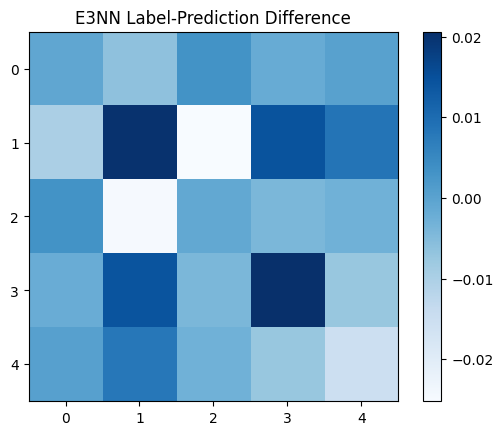

In [27]:
import matplotlib.pyplot as plt

plt.imshow(diff.detach().numpy(), cmap='Blues', interpolation='none')
plt.colorbar()
plt.title("E3NN Label-Prediction Difference") 
plt.show()